In [1]:
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
sys.path.append('..')
import lib

In [2]:
n_qubits = 3
dim = 2 ** n_qubits
rho = lib.randomPureState(dim)


projectors_cnt = 100_000
measurements_cnt = 10_000

train_X, train_y = lib.generate_dataset(rho, projectors_cnt, measurements_cnt)
train_y = train_y.astype('float64')

In [3]:
sigma = tf.Variable(tf.eye(dim, dtype=tf.complex64) * (2 ** -n_qubits))

x_var = tf.Variable(train_X, dtype=tf.complex64)
y_var = tf.Variable(train_y, dtype=tf.float32)

T = 100_000
L = 1
loss_object = tf.keras.losses.MeanAbsoluteError()

eta = np.sqrt(np.log(2) * n_qubits / 4 / T)
regret_bound = 2 * L * np.sqrt(np.log(2) * T * n_qubits)

print('eta:\t\t', eta)
print('regret_bound:\t', regret_bound)

eta:		 0.0022800447044300665
regret_bound:	 912.0178817720266


In [4]:
loss_history = []
metrics_history = []
fidelity_history = []

cum_grad = tf.Variable(tf.zeros([dim, dim], dtype=tf.complex64))
measurements_rho = np.array([lib.simulator.bornRule(x, rho) for x in train_X[T:]])

In [5]:
pred = tf.math.real(tf.linalg.trace(tf.einsum('bik,kj->bij', x_var[:T], rho)))
tf.math.reduce_sum(tf.abs(pred - train_y[:T]))

<tf.Tensor: shape=(), dtype=float32, numpy=231.0109>

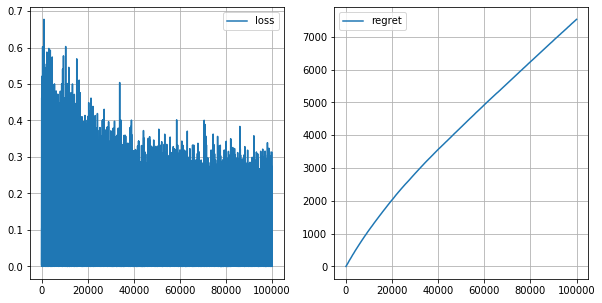

In [10]:
for t in range(T):  
    
    with tf.GradientTape() as tape:
        trace = tf.math.real(tf.linalg.trace(tf.matmul(x_var[t], sigma)))
        loss = tf.abs(trace - y_var[t])
    
    grad = tf.matmul(tape.gradient(loss, sigma), x_var[t])
    cum_grad = cum_grad + grad

    sigma = tf.exp(-cum_grad * eta / L)
    sigma = tf.Variable(sigma / tf.linalg.trace(sigma))
    
    loss_history.append(loss)
    
    if t % 5 == 0:
        clear_output(True)
        plt.figure(figsize=[10, 5])
        plt.subplot(1, 2, 1)
        plt.plot(loss_history, label='loss')
        plt.legend()
        plt.grid()
        plt.subplot(1, 2, 2)
        plt.plot(np.cumsum(loss_history), label='regret')
        plt.legend()
        plt.grid()
        plt.show()